In [1]:
#i Importing the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV


import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Loading and viewing the data
df = pd.read_csv('Thyroid_Diff.csv')
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [3]:
# Checking the shape of the data
row,col = df.shape
f'Our datafame has {row} rows and {col} columns'

'Our datafame has 383 rows and 17 columns'

In [4]:
# Checking the basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [5]:
# Checking for nan values
df.isna().sum()

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64

In [6]:
# Checking for duplicates
df.duplicated().sum()

19

In [7]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Confirming if there are still duplicates
df.duplicated().sum()

0

In [9]:
# Performing descriptive statistics
df.describe()

,Age
count,364.00000
mean,41.25000
std,15.31436
min,15.00000
25%,30.00000
50%,38.00000
75%,52.00000
max,82.00000


In [10]:
# Checking the class balance
df['Recurred'].value_counts(normalize=True)

No     0.703297
Yes    0.296703
Name: Recurred, dtype: float64

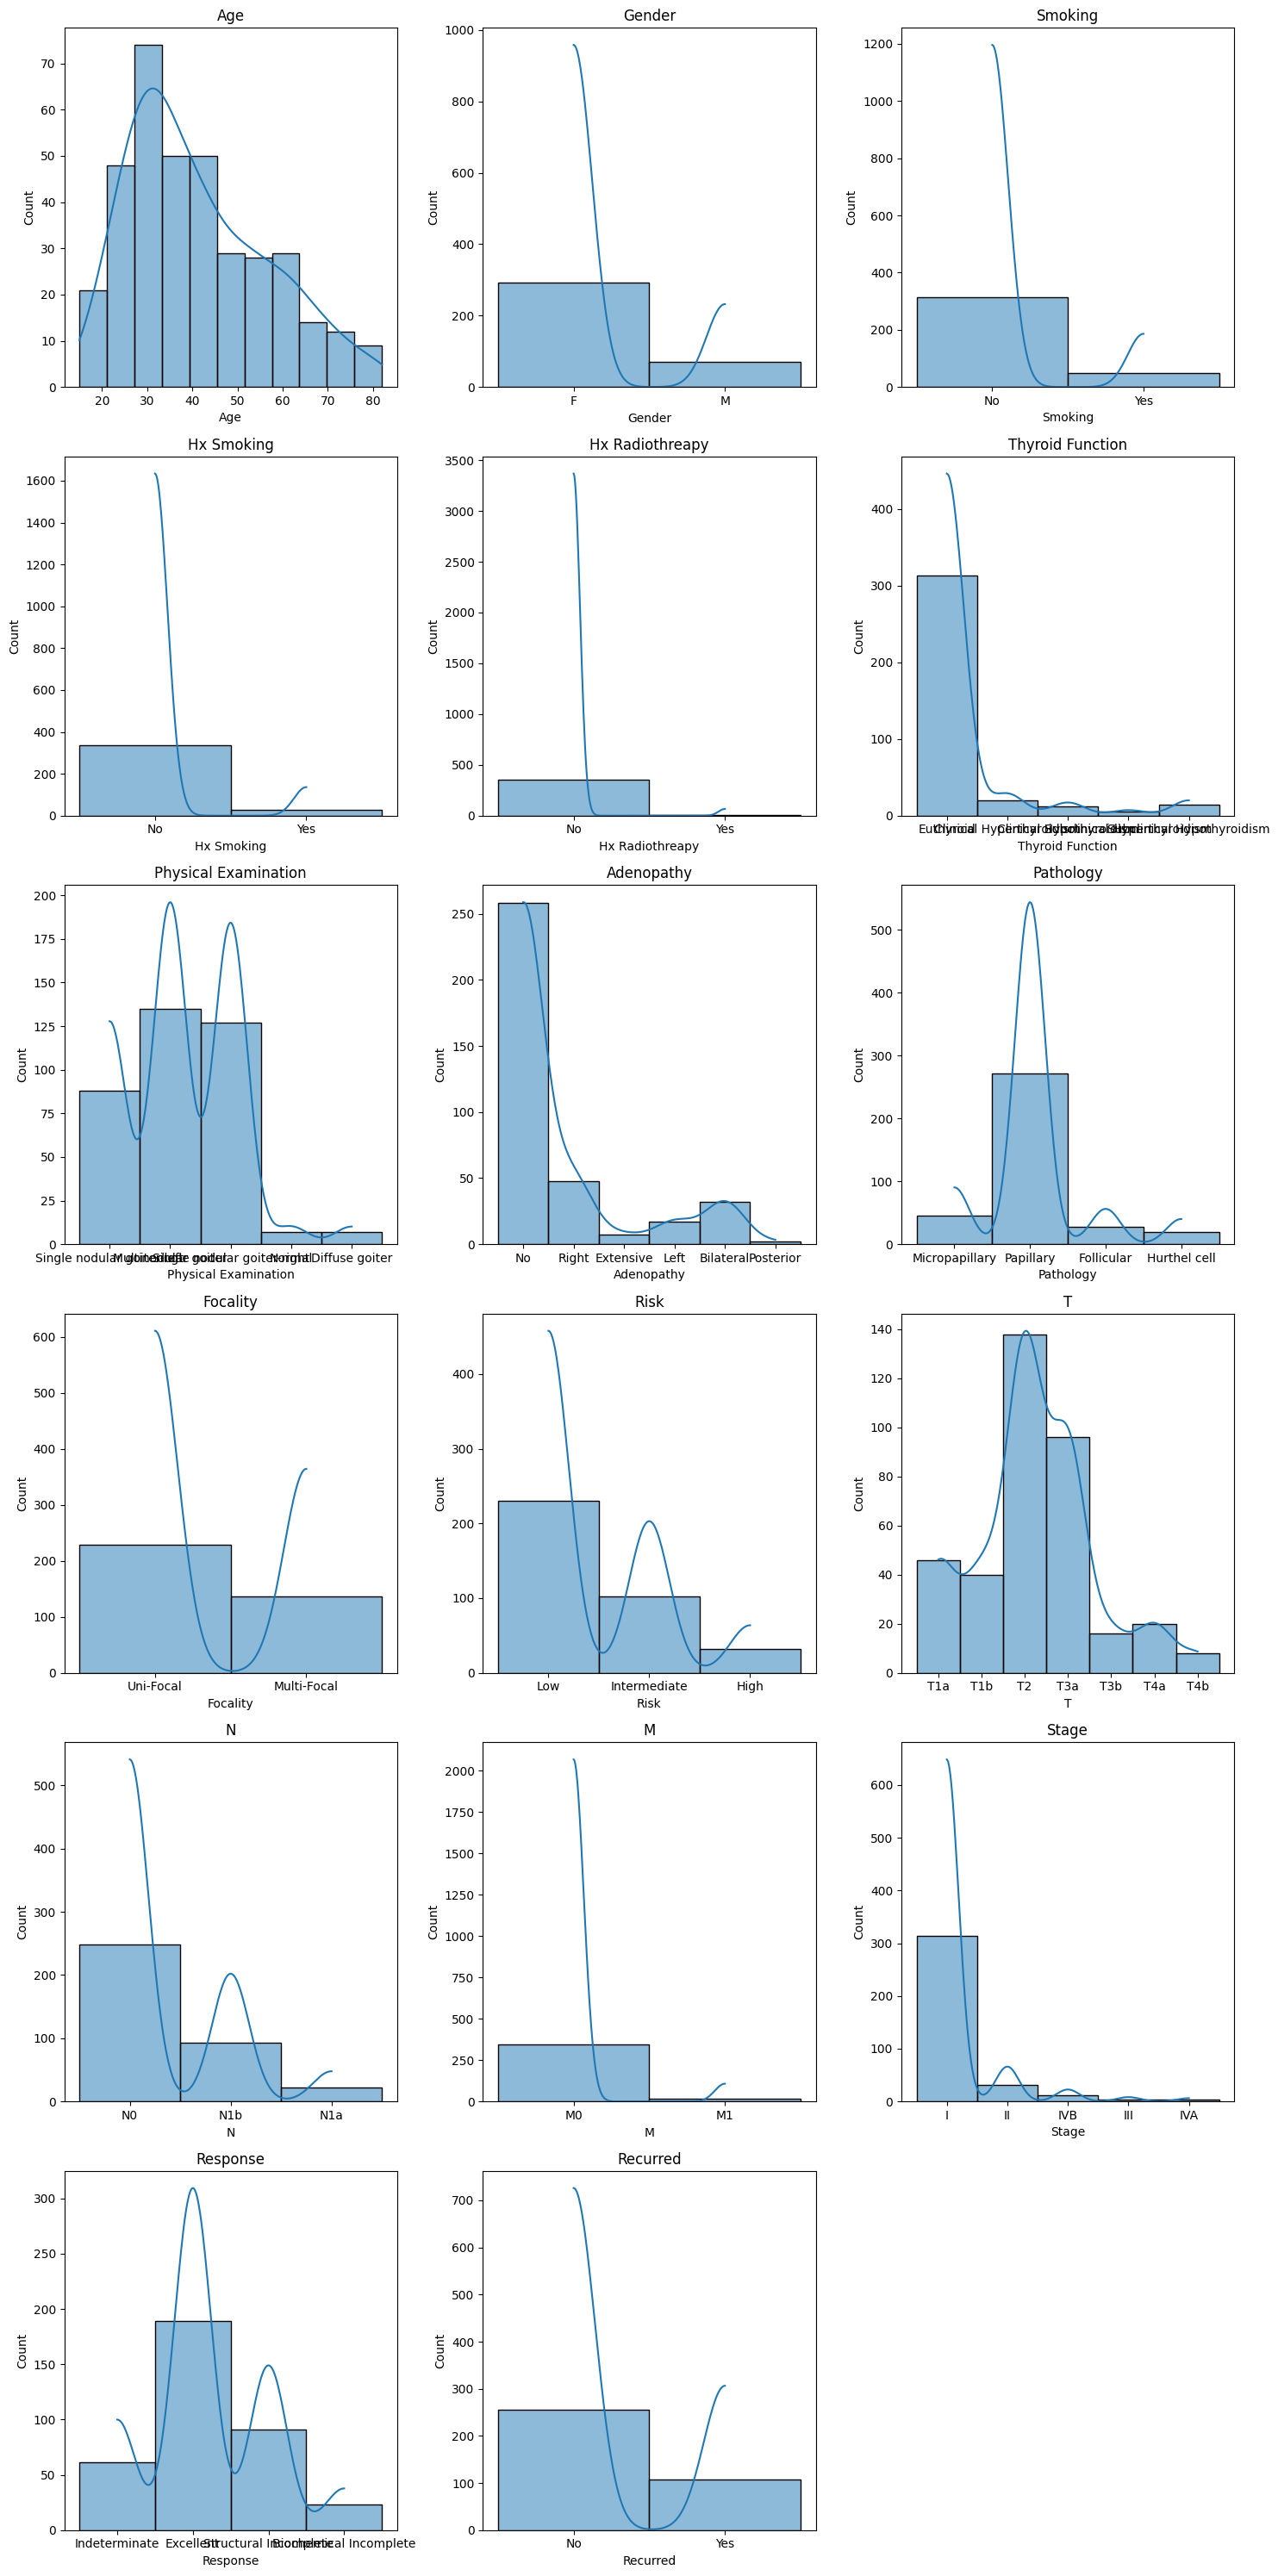

In [11]:
# Ploting the data distribution
num_features = len(df.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows dynamically

plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size

for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)
    
plt.tight_layout()
plt.show()

In [12]:
# Converting the categorical columns to numeric one
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

In [13]:
# Correlation Matrix
correlation_matrix = df.corr()

# Feature Selection: Select features highly correlated with 'Recurred'
threshold = 0.2  # Threshold for correlation
correlated_features_series = correlation_matrix['Recurred'][abs(correlation_matrix['Recurred']) > threshold]
correlated_features = correlated_features_series.sort_values(ascending=False).index.tolist()

# Displaying correlation coefficients of selected features
print("Correlation Coefficients of Highly Correlated Features with 'Recurred':")
correlated_features_series

Correlation Coefficients of Highly Correlated Features with 'Recurred':


Age         0.248926
Gender      0.317731
Smoking     0.325300
Focality   -0.368581
Risk       -0.727404
T           0.553318
N           0.624538
M           0.351161
Stage       0.444569
Response    0.702864
Recurred    1.000000
Name: Recurred, dtype: float64

**Feature Correlation with Cancer Recurrence:**

**Positive Impact on Recurrence:**

`Gender, Smoking, T, N, M, Stage, Response`

**Negative Impact on Recurrence:**

`Focality, Risk`

**Correlation indicates the strength of the relationship but doesn't imply causation.**

In [14]:
# Displaying correlation coefficients of selected features
correlation_coefficients = correlation_matrix.loc[correlated_features, correlated_features]
print("Correlation Coefficients of Highly Correlated Features with 'Recurred':")
correlation_coefficients

Correlation Coefficients of Highly Correlated Features with 'Recurred':


,Recurred,Response,N,T,Stage,M,Smoking,Gender,Age,Focality,Risk
Recurred,1.000000,0.702864,0.624538,0.553318,0.444569,0.351161,0.325300,0.317731,0.248926,-0.368581,-0.727404
Response,0.702864,1.000000,0.574994,0.454263,0.331857,0.301301,0.254237,0.261497,0.168765,-0.340633,-0.597216
N,0.624538,0.574994,1.000000,0.453259,0.267379,0.214455,0.194418,0.226706,0.046282,-0.361117,-0.689871
T,0.553318,0.454263,0.453259,1.000000,0.539228,0.388778,0.374477,0.264752,0.245350,-0.448142,-0.680349
Stage,0.444569,0.331857,0.267379,0.539228,1.000000,0.680005,0.422574,0.244470,0.527409,-0.325250,-0.617295
M,0.351161,0.301301,0.214455,0.388778,0.680005,1.000000,0.318424,0.207512,0.233240,-0.216742,-0.501961
Smoking,0.325300,0.254237,0.194418,0.374477,0.422574,0.318424,1.000000,0.618390,0.305131,-0.227818,-0.366606
Gender,0.317731,0.261497,0.226706,0.264752,0.244470,0.207512,0.618390,1.000000,0.177827,-0.193086,-0.283486
Age,0.248926,0.168765,0.046282,0.245350,0.527409,0.233240,0.305131,0.177827,1.000000,-0.210916,-0.285706
Focality,-0.368581,-0.340633,-0.361117,-0.448142,-0.325250,-0.216742,-0.227818,-0.193086,-0.210916,1.000000,0.435928


In [15]:
# Now, let's calculate the correlation matrix and focus on the 'Recurred' column.
correlation_matrix = df.corr()
correlation_with_recurrence = correlation_matrix.loc['Recurred'].sort_values(ascending=False)

correlation_with_recurrence

Recurred                1.000000
Response                0.702864
N                       0.624538
T                       0.553318
Stage                   0.444569
M                       0.351161
Smoking                 0.325300
Gender                  0.317731
Age                     0.248926
Hx Radiothreapy         0.171796
Hx Smoking              0.128472
Thyroid Function        0.071077
Pathology               0.014230
Physical Examination   -0.122076
Adenopathy             -0.182313
Focality               -0.368581
Risk                   -0.727404
Name: Recurred, dtype: float64

In [16]:
# Select only categorical columns from the DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

In [17]:
# One-hot encode the categorical columns
one_hot_encoded_df = pd.get_dummies(df, columns=categorical_columns)

# Display the resulting DataFrame after one-hot encoding
one_hot_encoded_df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


**The one hot encoder was used to comapre what was obtained using label enconder**

In [18]:
# Correlation Matrix
correlation_matrix = one_hot_encoded_df.corr()

# Feature Selection: Select features highly correlated with 'Recurred'
threshold = 0.2  # Define a threshold for correlation
correlated_features_series = correlation_matrix['Recurred'][abs(correlation_matrix['Recurred']) > threshold]
correlated_features = correlated_features_series.sort_values(ascending=False).index.tolist()

# Displaying correlation coefficients of selected features
print("Correlation Coefficients of Highly Correlated Features with 'Recurred':")
correlated_features_series

Correlation Coefficients of Highly Correlated Features with 'Recurred':


Age         0.248926
Gender      0.317731
Smoking     0.325300
Focality   -0.368581
Risk       -0.727404
T           0.553318
N           0.624538
M           0.351161
Stage       0.444569
Response    0.702864
Recurred    1.000000
Name: Recurred, dtype: float64

In [19]:
# Calculate VIF for all numerical features
numerical_features = ['Age', 'Gender', 'Smoking', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']
X = df[numerical_features]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factor (VIF):")
vif_data

Variance Inflation Factor (VIF):


,Features,VIF
0,Age,10.163960
1,Gender,2.075292
2,Smoking,2.203869
3,Focality,3.314155
4,Risk,8.584502
5,T,5.733622
6,N,2.696454
7,M,2.062240
8,Stage,3.572013
9,Response,6.263448


**The Variance Inflation Factor (VIF) measures how much the variance of an estimated regression coefficient increases if predictors are highly correlated.**

**In this context:**

**High VIF (Above 5-10) for 'Age', 'Risk', 'T', 'Stage', 'Response' suggests potential multicollinearity issues (high correlation among these features), which may affect the reliability of regression coefficients.**

**Low VIF (Below 5) for 'Gender', 'Smoking', 'Focality', 'N', 'M' indicates lower correlation and less impact on increasing variance in regression coefficients, showing less multicollinearity concern.**

In [20]:
X = df[['Gender','Smoking','Focality','N','M','Stage']]
y= df['Recurred']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Accuracy: 86.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        51
           1       0.75      0.82      0.78        22

    accuracy                           0.86        73
   macro avg       0.83      0.85      0.84        73
weighted avg       0.87      0.86      0.86        73



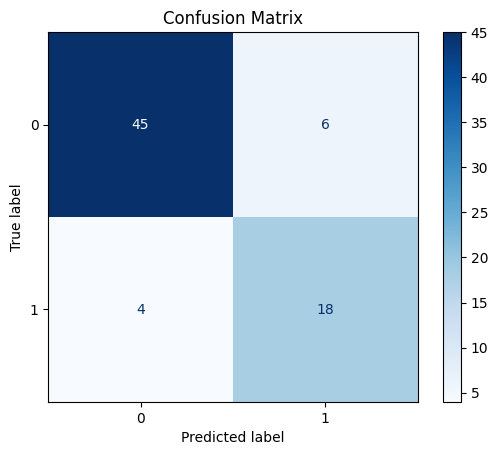


Cross-Validation Scores: [0.91525424 0.84482759 0.79310345 0.84482759 0.84482759]
Mean Accuracy from Cross-Validation: 84.86%


In [28]:
# Initialize Decision Tree Classifier with default parameters
baseline_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = baseline_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1 Score
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# Plot confusion matrix
plot_confusion_matrix(baseline_model, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Perform cross-validation
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean Accuracy from Cross-Validation: {cv_scores.mean()*100:.2f}%")


AUC: 0.8601
Optimal Threshold: 0.5714285714285714


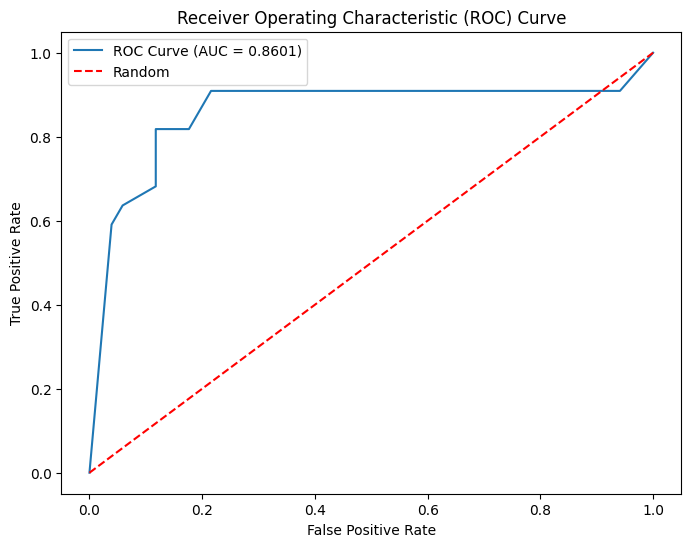

In [43]:
# Get predicted probabilities for the positive class
probs = baseline_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate AUC
auc = roc_auc_score(y_test, probs)
print(f"\nAUC: {auc:.4f}")

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [30]:
# Get feature importances from the model
feature_importance = baseline_model.feature_importances_

# Get feature names from the DataFrame columns
feature_names = X.columns.tolist()

# Create a sorted list of feature importance indices
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance along with corresponding feature names
print("Feature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]}")


Feature Importance:
N: 0.7171953077650408
Stage: 0.13370187092971003
Smoking: 0.0614949493636197
Focality: 0.05341606141210011
Gender: 0.021613715215509584
M: 0.012578095314019728



Accuracy: 87.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        51
           1       0.76      0.86      0.81        22

    accuracy                           0.88        73
   macro avg       0.85      0.87      0.86        73
weighted avg       0.88      0.88      0.88        73



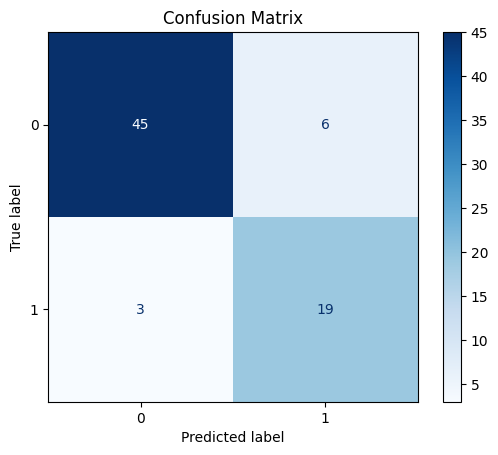


Cross-Validation Scores: [0.89830508 0.84482759 0.79310345 0.84482759 0.84482759]
Mean Accuracy from Cross-Validation: 84.52%


In [31]:
# Initialize Random Forest Classifier with default parameters
random_forest = RandomForestClassifier(random_state=42)

# Fit the model on the training data
random_forest.fit(X_train, y_train)

# Make predictions on the test set
predictions = random_forest.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1 Score
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# Plot confusion matrix
plot_confusion_matrix(random_forest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Perform cross-validation
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean Accuracy from Cross-Validation: {cv_scores.mean()*100:.2f}%")


AUC: 0.8890
Optimal Threshold: 0.5693214285714285


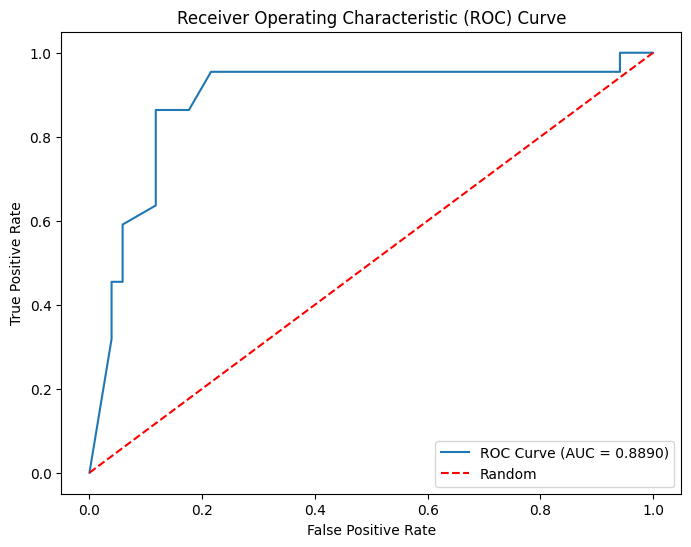

In [42]:
# Get predicted probabilities for the positive class
probs = random_forest.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate AUC
auc = roc_auc_score(y_test, probs)
print(f"\nAUC: {auc:.4f}")

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [33]:
# Get feature importances from the model
feature_importance = random_forest.feature_importances_

# Get feature names from the DataFrame columns
feature_names = X.columns.tolist()

# Create a sorted list of feature importance indices
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance along with corresponding feature names
print("Feature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]}")


Feature Importance:
N: 0.5466122665639788
Stage: 0.18532883112250229
Focality: 0.09023011507388605
Gender: 0.07181505577155396
M: 0.05468497563031215
Smoking: 0.05132875583776684



Accuracy: 86.30%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        51
           1       0.75      0.82      0.78        22

    accuracy                           0.86        73
   macro avg       0.83      0.85      0.84        73
weighted avg       0.87      0.86      0.86        73



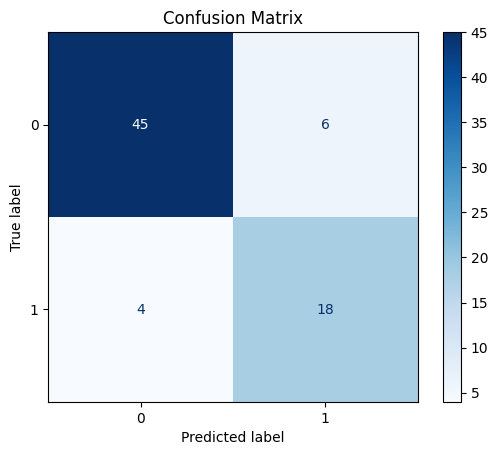


Cross-Validation Scores: [0.88135593 0.86206897 0.79310345 0.84482759 0.82758621]
Mean Accuracy from Cross-Validation: 84.18%


In [34]:
# Initialize Gradient Boosting Classifier with default parameters
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
gradient_boosting.fit(X_train, y_train)

# Make predictions on the test set
predictions = gradient_boosting.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1 Score
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# Plot confusion matrix
plot_confusion_matrix(gradient_boosting, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Perform cross-validation
cv_scores = cross_val_score(gradient_boosting, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("\nCross-Validation Scores:", cv_scores)
print(f"Mean Accuracy from Cross-Validation: {cv_scores.mean()*100:.2f}%")


AUC: 0.9051
Optimal Threshold: 0.3992143729075194


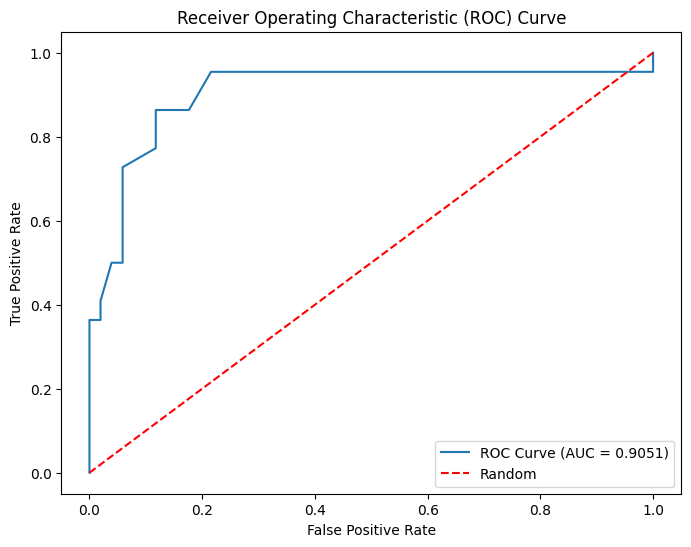

In [38]:
# Get predicted probabilities for the positive class
probs = gradient_boosting.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate AUC
auc = roc_auc_score(y_test, probs)
print(f"\nAUC: {auc:.4f}")

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [40]:
# Thresholding using the optimal threshold
predictions_optimal_threshold = (probs >= optimal_threshold).astype(int)
predictions_optimal_threshold

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1])

In [36]:
# Get feature importances from the model
feature_importance = gradient_boosting.feature_importances_

# Get feature names from the DataFrame columns
feature_names = X.columns.tolist()

# Create a sorted list of feature importance indices
sorted_idx = np.argsort(feature_importance)[::-1]

# Print feature importance along with corresponding feature names
print("Feature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importance[i]}")


Feature Importance:
N: 0.7271817643480469
Stage: 0.13567993707802833
Smoking: 0.042002280113645894
Gender: 0.040410525428339464
Focality: 0.037987237917716965
M: 0.016738255114222344


In [52]:
def classify_with_threshold(probability, threshold):
    return 'Yes' if probability >= threshold else 'No'

def get_user_input():
    gender = input("Enter gender (e.g., 'Male' or 'Female'): ")
    smoking = input("Enter smoking status (e.g., 'Smoker' or 'Non-smoker'): ")
    focality = input("Enter focality (e.g., 'Unifocal' or 'Multifocal'): ")
    n = int(input("Enter value for 'N' (e.g., an integer value): "))
    m = int(input("Enter value for 'M' (e.g., an integer value): "))
    stage = int(input("Enter stage (e.g., an integer value): "))

    user_data = {
        'Gender': gender,
        'Smoking': smoking,
        'Focality': focality,
        'N': n,
        'M': m,
        'Stage': stage
    }

    return user_data

# Loop to continuously accept user input
while True:
    user_input = get_user_input()
    
    # Process the user input
    processed_user_input = preprocess_input(user_input)  # Replace with your preprocessing function
    
    # Make predictions using the processed user input
    try:
        predicted_prob = gradient_boosting.predict_proba([list(processed_user_input.values())])[:, 1]
        print(f"Predicted Probability for Cancer Recurrence: {predicted_prob[0]:.4f}")

        # Classify predictions using optimal threshold
        rounded_predictions = [classify_with_threshold(prob, optimal_threshold) for prob in predicted_prob]
        print("Predicted Classifications:")
        for i, prediction in enumerate(rounded_predictions):
            print(f"Prediction {i + 1}: {prediction}")

    except Exception as e:
        print("Error:", e)
    
    # Ask the user if they want to input new data or exit
    choice = input("\nEnter 'Y' to input new data, or any other key to exit: ")
    if choice.upper() != 'Y':
        break


Enter gender (e.g., 'Male' or 'Female'): Male
Enter smoking status (e.g., 'Smoker' or 'Non-smoker'): Smoker
Enter focality (e.g., 'Unifocal' or 'Multifocal'): Unifocal
Enter value for 'N' (e.g., an integer value): 1
Enter value for 'M' (e.g., an integer value): 1
Enter stage (e.g., an integer value): 1
Predicted Probability for Cancer Recurrence: 0.7798
Predicted Classifications:
Prediction 1: Yes

Enter 'Y' to input new data, or any other key to exit: n
